# 3 layer non linear input output auto encoder

In [66]:
import pandas as pd
import numpy as np
IntrusionData = pd.read_csv('data.csv',sep=',',index_col = False)
Xmatrix = IntrusionData.values
LabelVector = Xmatrix[:,-1]
Xmatrix = Xmatrix[:,:-1]
meanVector = np.mean(Xmatrix,axis = 0)
CenteredXmatrix = Xmatrix - meanVector
SdVector = np.std(CenteredXmatrix.astype(float),axis = 0)
CenteredXmatrix /= SdVector
Xmatrix1 = CenteredXmatrix

In [80]:
inputeLayerSize = 29
hiddenLayerSize = 10
outputLayerSize = 29
#numOfHiddenLayers = 1
#initialize weights and biases 
Weights ={}
Biases ={}
#hiddenLayerSizes1 = [27,25,23,20,14,20,23,25,27]
#hiddenLayerSizes1 = [20,14,20]
hiddenLayerSizes1 = [14]
numOfHiddenLayers = len(hiddenLayerSizes1)

#method = 'linear'
method = 'Sigmoid'
#method = 'Relu'
#method = 'tanhx'

In [81]:
for i in range(0,len(hiddenLayerSizes1)):
    if(i==0):        
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],inputeLayerSize)*np.sqrt(2/inputeLayerSize)
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/inputeLayerSize)
    else:
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],hiddenLayerSizes1[i-1])*np.sqrt(2/hiddenLayerSizes1[i-1])
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/hiddenLayerSizes1[i-1])

Weights[numOfHiddenLayers] = np.random.randn(outputLayerSize,hiddenLayerSizes1[numOfHiddenLayers-1])*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])
Biases[numOfHiddenLayers] = np.random.randn(outputLayerSize,1)*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])

In [82]:
for i in Weights:
    print(Weights[i].shape)

(14, 29)
(29, 14)


In [83]:
def getSigmoid(x,method):
    x = x.astype(float)
    if(method == 'Sigmoid'):
        x = np.clip(x,-500,500)
        return 1/(1+np.exp(-x))        
    elif(method == 'Relu'):
        #x = np.clip(x,-500,+500)
        return np.maximum(x, 0)
        #return (abs(x) + x) / 2         
    elif(method == 'tanhx'):
        return (2*(getSigmoid(2*x,'Sigmoid')))-1
    elif(method == 'linear'):
        return x
    
def getSigmoidDash(x,method):
    if(method == 'Sigmoid'):
        tempDer3 = x.copy()
        tempDer3[tempDer3.all()>-500 and tempDer3.all()<500] = 1.0
        tempDer3[tempDer3.all()>500 and tempDer3.all()<-500] = 0.0
        #tempDer1 = np.array([1.0 if (t.any()>-500 and t.any()<500) else 0.0 for t in x])
        #tempDer1 = tempDer1.reshape(x.shape[0],x.shape[1])
        tempDer2 = getSigmoid(x,method)*(1-getSigmoid(x,method))
        return tempDer2*tempDer3
        return getSigmoid(x,method)*(1-getSigmoid(x,method))
    elif(method == 'Relu'):
        x[x<=0] = 0
        x[x>0] = 1.0        
        return x
    elif(method == 'tanhx'):
        return (1 - (getSigmoid(x,'tanhx'))**2)
    elif(method == 'linear'):
        return x/x

In [84]:
Xmatrix1 = Xmatrix1[0:24900,:]

In [85]:
numOfHiddenLayers

1

In [86]:
TrainErrorInEachEpoch = []
ValErrorInEachEpoch = []
numOfIterInEachEpochs = 100
batchSize = 249
for epoch in range(0,300):
    print("Epoch is "+str(epoch))
    for j in range(0,numOfIterInEachEpochs):
        #print("Iteration is "+str(j))
        Xmatrix = Xmatrix1[0+(j*batchSize):batchSize+(j*batchSize),:]
        #forward pass
        z = {}
        z[-1] = Xmatrix.T
        for i in range(0,numOfHiddenLayers):#np.reshape(a, (3,1))
            if(i==0):
                z[i] = (Weights[i]@getSigmoid(z[-1].astype(float),method))+Biases[i]  
                #z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
                #print(z[i].shape)
            else:                
                z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
                #print(z[i].shape)  
        z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@getSigmoid(z[numOfHiddenLayers-1],method))+Biases[numOfHiddenLayers]        
        #z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]
        Yhat = z[numOfHiddenLayers].astype(float)
        YvectorModified = z[-1].astype(float)
        Cost = np.linalg.norm(Yhat-YvectorModified, ord=2)
        #Cost = np.sum((np.array(Yhat-YvectorModified)**2).sum(axis=0))        
        
        #print(Cost)
        
        #backwardprop
        
        GradWeights = {}
        GradBiases = {}

        DcostDAct = {}

        DcostDAct[numOfHiddenLayers-1] = ((Weights[numOfHiddenLayers].T)@(Yhat-YvectorModified))
        
        #for temp3 in range(numOfHiddenLayers-2,0,-1):
            #DcostDAct[temp3] = (Weights[temp3+1].T)@(getSigmoidDash(z[temp3+1],method)*DcostDAct[temp3+1])  
        
        #DcostDAct[0] = (Weights[1].T)@(1*DcostDAct[1])
        
        GradWeights[numOfHiddenLayers] = (Yhat-YvectorModified)@(getSigmoid(z[numOfHiddenLayers-1].T,method))
        GradBiases[numOfHiddenLayers] = (Yhat-YvectorModified).sum(axis=1)
        
        for temp1 in range(numOfHiddenLayers-1,-1,-1):
            GradWeights[temp1] = ((getSigmoidDash(z[temp1],method)*DcostDAct[temp1])@getSigmoid(z[temp1-1].T,method))
            GradBiases[temp1] = (getSigmoidDash(z[temp1],method)*DcostDAct[temp1]).sum(axis=1)
            
        #GradWeights[0] = ((DcostDAct[0])@(z[-1].T.astype(float)))
        #GradBiases[0] = (DcostDAct[0]).sum(axis=1) 
      
        for item in GradBiases:
            GradBiases[item] = GradBiases[item].reshape(GradBiases[item].shape[0],1)
          
        
       
        #finding gradients and updating weights and biases      
            
        for temp6 in Weights:
            Weights[temp6] =  Weights[temp6] - ((5*10**(-4))*GradWeights[temp6])
        for temp7 in Biases:
            Biases[temp7] = Biases[temp7] - ((5*10**(-4))*GradBiases[temp7]) #*(1/batchSize)           
    print(Cost)    
    #trainError = getError(train,Weights,Biases,numOfHiddenLayers,'yes')
    #valError = getError(val,Weights,Biases,numOfHiddenLayers,'no')
    #TrainErrorInEachEpoch.append(trainError)
    #ValErrorInEachEpoch.append(valError)
    #print(trainError)
    #print(valError)
    #if(epoch == 14):
    #Cost = getLoss(train,Weights,Biases,numOfHiddenLayers)
    #print(Cost)
    #ValErrorInEachEpoch.append(Cost)
     #   CostAtEndOffiftyEpochs[numOfHiddenLayers]=(getLoss(train,Weights,Biases,numOfHiddenLayers))
    #if(valError > trainError):
     #   break


Epoch is 0
20.405249748664726
Epoch is 1
19.014347908523888
Epoch is 2
18.85541536025652
Epoch is 3
18.734248465518743
Epoch is 4
18.599479820567804
Epoch is 5
18.454036827654804
Epoch is 6
18.301747235207547
Epoch is 7
18.139213652479324
Epoch is 8
17.965054148674636
Epoch is 9
17.774557992953227
Epoch is 10
17.567896776742412
Epoch is 11
17.351907524953095
Epoch is 12
17.138057974409538
Epoch is 13
16.93397953209298
Epoch is 14
16.743241178912005
Epoch is 15
16.5757563254228
Epoch is 16
16.43266948698192
Epoch is 17
16.27274889626325
Epoch is 18
16.11888357789364
Epoch is 19
15.965095245188328
Epoch is 20
15.833305752977349
Epoch is 21
15.654758900678932
Epoch is 22
16.608300060049544
Epoch is 23
15.441187178532571
Epoch is 24
15.273506791569853
Epoch is 25
15.062747713034625
Epoch is 26
15.213133735356969
Epoch is 27
14.825244171445128
Epoch is 28
14.68563084574744
Epoch is 29
14.609509691431194
Epoch is 30
14.508881109660017
Epoch is 31
14.445440329322416
Epoch is 32
14.39238692790

11.210116849027413
Epoch is 262
11.234762126872925
Epoch is 263
11.23361417175858
Epoch is 264
11.225895381530396
Epoch is 265
11.235019061238749
Epoch is 266
11.254729220716413
Epoch is 267
11.240222616925855
Epoch is 268
11.257551230499892
Epoch is 269
11.26522462039288
Epoch is 270
11.264674634273838
Epoch is 271
11.26660777854
Epoch is 272
11.319711217771886
Epoch is 273
11.30444959838481
Epoch is 274
11.2745072556292
Epoch is 275
11.298414894935007
Epoch is 276
11.31066911634612
Epoch is 277
11.299175690843587
Epoch is 278
11.306023457233199
Epoch is 279
11.349282475475455
Epoch is 280
11.321853016114252
Epoch is 281
11.333702134793727
Epoch is 282
11.325165989339586
Epoch is 283
11.323544821016968
Epoch is 284
11.332755485091482
Epoch is 285
11.354495432154645
Epoch is 286
11.342790931572031
Epoch is 287
11.34624091832702
Epoch is 288
11.387786396234608
Epoch is 289
11.357222883685658
Epoch is 290
11.440383327690496
Epoch is 291
11.3576241468394
Epoch is 292
11.37798034567929
Epo

In [93]:
z[0].shape

(14, 249)

In [94]:
z = {}
z[-1] = Xmatrix1.T
for i in range(0,1):#np.reshape(a, (3,1))
    if(i==0):
        z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
        #print(z[i].shape)
    else:                
        z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
        #print(z[i].shape)        
#z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]
reconstructedXmatrix = z[0].T

In [95]:
reconstructedXmatrix = z[0].T

In [96]:
reconstructedXmatrix.shape

(24900, 14)

In [97]:
k = 5
meanVector = {}
import random
RandomIndices = random.sample(range(0,len(reconstructedXmatrix)), 5)
#RandomIndices = [15126, 24342, 8449, 19992, 6418]
print(RandomIndices)
for i in range(0,k):
    #meanVector[i] = 
    meanVector[i] = reconstructedXmatrix[RandomIndices[i],:]

[1388, 124, 22243, 8689, 15595]


In [98]:
def getDistance(row1,row2):
    row1 = np.array(row1)
    row2 = np.array(row2)
    return (np.sum((np.abs(row1-row2))**2))**(1/2)
def getNearestClusterDistance(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    #nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanDistance
def getNearestCluster(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    #nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanLabel

In [99]:
iterationNumber = 0
#while (iterationNumber<30):
AssociatedClusterForEachPoint1 = []
import operator
while(True):
#for i in range(0,10)
    iterationNumber += 1
    print("iteration number "+str(iterationNumber))
    beforeAssociatedClusterForEachPoint1 = AssociatedClusterForEachPoint1.copy()
    AssociatedClusterForEachPoint1 = []
    for i in range(0,len(reconstructedXmatrix)):
        AssociatedClusterForEachPoint1.append(getNearestCluster(reconstructedXmatrix[i,:],meanVector))
    if(beforeAssociatedClusterForEachPoint1 == AssociatedClusterForEachPoint1):
        break
    distanceOfallPointsToTheirNearestMeans = 0
    for i in range(0,len(reconstructedXmatrix)):
        distanceOfallPointsToTheirNearestMeans += (getNearestClusterDistance(reconstructedXmatrix[i,:],meanVector))
    print('distanceOfallPointsToTheirNearestMeans is '+str(distanceOfallPointsToTheirNearestMeans))
    #distanceOfallPointsToTheirNearestMeans = 0
    for i in meanVector:
        numerVector = np.array([0.0]*len(meanVector[0]))
        count = 0
        for j,value in enumerate(AssociatedClusterForEachPoint1):
            if value == i:
                numerVector += reconstructedXmatrix[j,:]
                #print(reconstructedXmatrix[j,:])
                count += 1
        if count!= 0:
            print("centriod number - "+str(i)+" have points "+str(count))            
            meanVector[i] = (numerVector/count)
        else:
            print('no points associated to mean number')
            print(i)    

iteration number 1
distanceOfallPointsToTheirNearestMeans is 433424.9565355544
centriod number - 0 have points 7745
centriod number - 1 have points 5955
centriod number - 2 have points 2642
centriod number - 3 have points 1309
centriod number - 4 have points 7249
iteration number 2
distanceOfallPointsToTheirNearestMeans is 368592.35119052266
centriod number - 0 have points 8911
centriod number - 1 have points 5001
centriod number - 2 have points 2934
centriod number - 3 have points 1151
centriod number - 4 have points 6903
iteration number 3
distanceOfallPointsToTheirNearestMeans is 364806.15635583206
centriod number - 0 have points 9560
centriod number - 1 have points 4460
centriod number - 2 have points 2947
centriod number - 3 have points 1085
centriod number - 4 have points 6848
iteration number 4
distanceOfallPointsToTheirNearestMeans is 365517.7807823344
centriod number - 0 have points 10219
centriod number - 1 have points 3863
centriod number - 2 have points 2945
centriod number

In [102]:
conMatrix = pd.crosstab(np.array(AssociatedClusterForEachPoint1),LabelVector[0:24900])

In [103]:
tempo = pd.DataFrame(conMatrix)
tempo

col_0,dos,normal,probe,r2l,u2r
row_0,,,,,
0,440,10901,167,93,9
1,57,1302,1063,92,1
2,1356,541,998,11,0
3,447,544,2,0,0
4,6773,27,75,1,0


In [104]:
tempo['label']=tempo.idxmax(axis=1)

In [105]:
for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))

purity of cluster 0 is 0.938931955211025 and its label is normal
purity of cluster 1 is 0.5176938369781312 and its label is normal
purity of cluster 2 is 0.4666207845836201 and its label is dos
purity of cluster 3 is 0.5478348439073515 and its label is normal
purity of cluster 4 is 0.9850203606748109 and its label is dos


In [106]:
LabelVector = LabelVector[0:24900]

In [107]:
from sklearn import mixture
#clusterer = GaussianMixture(5, 'diag')
#clusterer.fit(reconstructedXmatrix)
#cluster_labels = clusterer.predict(reconstructedXmatrix)
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full',
                              max_iter=400,random_state= 0,n_init=20, init_params='kmeans').fit(reconstructedXmatrix)
labels = gmm.predict(reconstructedXmatrix)
zippedLabel = zip(labels,LabelVector)
conMatrix = pd.crosstab(labels,LabelVector)
#print(conMatrix)
tempo1 = pd.DataFrame(conMatrix)
tempo1

col_0,dos,normal,probe,r2l,u2r
row_0,,,,,
0,7483,0,0,0,0
1,0,7,0,0,0
2,0,6721,0,0,0
3,711,4379,1248,98,3
4,879,2208,1057,99,7


In [108]:
tempo1['label']=tempo1.idxmax(axis=1)

In [109]:
for i in tempo1.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo1.iloc[[i],:-1].values))/np.sum(np.array(tempo1.iloc[[i],:-1].values)))+" and its label is "+str(tempo1.at[i,'label']))

purity of cluster 0 is 1.0 and its label is dos
purity of cluster 1 is 1.0 and its label is normal
purity of cluster 2 is 1.0 and its label is normal
purity of cluster 3 is 0.6800745457369157 and its label is normal
purity of cluster 4 is 0.5195294117647059 and its label is normal


In [110]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5,affinity='euclidean', linkage='single',compute_full_tree = 'auto') .fit(reconstructedXmatrix)
clustering 

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='single', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [111]:
labelsForAgClus = clustering.labels_

In [112]:
conMatrix = pd.crosstab(labelsForAgClus,LabelVector)
print(conMatrix)

col_0   dos  normal  probe  r2l  u2r
row_0                               
0         0       6      0    0    0
1      9073   13307   2304  197   10
2         0       1      0    0    0
3         0       0      1    0    0
4         0       1      0    0    0


In [113]:
tempo = pd.DataFrame(conMatrix)
#tempo1
tempo['label']=tempo.idxmax(axis=1)

for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))

purity of cluster 0 is 1.0 and its label is normal
purity of cluster 1 is 0.534610903539432 and its label is normal
purity of cluster 2 is 1.0 and its label is normal
purity of cluster 3 is 1.0 and its label is probe
purity of cluster 4 is 1.0 and its label is normal


purity of cluster 0 is 0.938931955211025 and its label is normal
purity of cluster 1 is 0.5176938369781312 and its label is normal
purity of cluster 2 is 0.4666207845836201 and its label is dos
purity of cluster 3 is 0.5478348439073515 and its label is normal
purity of cluster 4 is 0.9850203606748109 and its label is dos

purity of cluster 0 is 1.0 and its label is dos
purity of cluster 1 is 1.0 and its label is normal
purity of cluster 2 is 1.0 and its label is normal
purity of cluster 3 is 0.6800745457369157 and its label is normal
purity of cluster 4 is 0.5195294117647059 and its label is normal

purity of cluster 0 is 1.0 and its label is normal
purity of cluster 1 is 0.534610903539432 and its label is normal
purity of cluster 2 is 1.0 and its label is normal
purity of cluster 3 is 1.0 and its label is probe
purity of cluster 4 is 1.0 and its label is normal

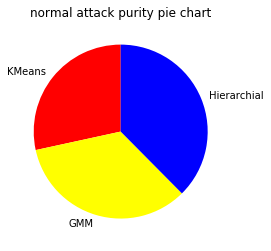

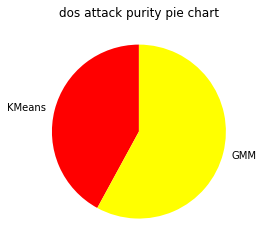

In [119]:
import matplotlib.pyplot as plt
slices_hours = [(0.938931955211025+0.5176938369781312+0.5478348439073515)/3,( 0.6800745457369157+0.5195294117647059+1+1)/4,(3+0.534610903539432)/4]
activities = ['KMeans', 'GMM','Hierarchial']
colors = ['r', 'yellow','blue']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('normal attack purity pie chart')
plt.show()
plt.show()

slices_hours = [( 0.4666207845836201+ 0.9850203606748109)/2,1]
activities = ['KMeans', 'GMM']
colors = ['r', 'yellow']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('dos attack purity pie chart')
plt.show()
plt.show()

slices_hours = [0.8070866141732284,1]
activities = ['KMeans', 'Hierarchial']
colors = ['r', 'yellow']
#plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
#plt.title('probe attack purity pie chart')
#plt.show()
#plt.show()

# 3 layer linear input output auto encoder

In [144]:
import pandas as pd
import numpy as np
IntrusionData = pd.read_csv('data.csv',sep=',',index_col = False)
Xmatrix = IntrusionData.values
LabelVector = Xmatrix[:,-1]
Xmatrix = Xmatrix[:,:-1]
meanVector = np.mean(Xmatrix,axis = 0)
CenteredXmatrix = Xmatrix - meanVector
SdVector = np.std(CenteredXmatrix.astype(float),axis = 0)
CenteredXmatrix /= SdVector
Xmatrix1 = CenteredXmatrix

In [145]:
inputeLayerSize = 29
hiddenLayerSize = 10
outputLayerSize = 29
#numOfHiddenLayers = 1
#initialize weights and biases 
Weights ={}
Biases ={}
#hiddenLayerSizes1 = [27,25,23,20,14,20,23,25,27]
#hiddenLayerSizes1 = [20,14,20]
hiddenLayerSizes1 = [14]
numOfHiddenLayers = len(hiddenLayerSizes1)

#method = 'linear'
method = 'Sigmoid'
#method = 'Relu'
#method = 'tanhx'

In [146]:
for i in range(0,len(hiddenLayerSizes1)):
    if(i==0):        
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],inputeLayerSize)*np.sqrt(2/inputeLayerSize)
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/inputeLayerSize)
    else:
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],hiddenLayerSizes1[i-1])*np.sqrt(2/hiddenLayerSizes1[i-1])
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/hiddenLayerSizes1[i-1])

Weights[numOfHiddenLayers] = np.random.randn(outputLayerSize,hiddenLayerSizes1[numOfHiddenLayers-1])*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])
Biases[numOfHiddenLayers] = np.random.randn(outputLayerSize,1)*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])

In [147]:
for i in Weights:
    print(Weights[i].shape)

(14, 29)
(29, 14)


In [148]:
for i in Weights:
    Weights[i] = 0.01*Weights[i]
    Biases[i] = 0.01*Biases[i]

In [149]:
def getSigmoid(x,method):
    x = x.astype(float)
    if(method == 'Sigmoid'):
        x = np.clip(x,-500,500)
        return 1/(1+np.exp(-x))        
    elif(method == 'Relu'):
        #x = np.clip(x,-500,+500)
        return np.maximum(x, 0)
        #return (abs(x) + x) / 2         
    elif(method == 'tanhx'):
        return (2*(getSigmoid(2*x,'Sigmoid')))-1
    elif(method == 'linear'):
        return x
    
def getSigmoidDash(x,method):
    if(method == 'Sigmoid'):
        tempDer3 = x.copy()
        tempDer3[tempDer3.all()>-500 and tempDer3.all()<500] = 1.0
        tempDer3[tempDer3.all()>500 and tempDer3.all()<-500] = 0.0
        #tempDer1 = np.array([1.0 if (t.any()>-500 and t.any()<500) else 0.0 for t in x])
        #tempDer1 = tempDer1.reshape(x.shape[0],x.shape[1])
        tempDer2 = getSigmoid(x,method)*(1-getSigmoid(x,method))
        return tempDer2*tempDer3
        return getSigmoid(x,method)*(1-getSigmoid(x,method))
    elif(method == 'Relu'):
        x[x<=0] = 0
        x[x>0] = 1.0        
        return x
    elif(method == 'tanhx'):
        return (1 - (getSigmoid(x,'tanhx'))**2)
    elif(method == 'linear'):
        return x/x

In [150]:
Xmatrix1 = Xmatrix1[0:24900,:]

In [151]:
TrainErrorInEachEpoch = []
ValErrorInEachEpoch = []
numOfIterInEachEpochs = 100
batchSize = 249
for epoch in range(0,300):
    print("Epoch is "+str(epoch))
    for j in range(0,numOfIterInEachEpochs):
        #print("Iteration is "+str(j))
        Xmatrix = Xmatrix1[0+(j*batchSize):batchSize+(j*batchSize),:]
        #forward pass
        z = {}
        z[-1] = Xmatrix.T
        for i in range(0,numOfHiddenLayers):#np.reshape(a, (3,1))
            if(i==0):
                z[i] = (Weights[i]@getSigmoid(z[-1].astype(float),'linear'))+Biases[i]  
                #z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
                #print(z[i].shape)
            else:                
                z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
                #print(z[i].shape)  
        z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@getSigmoid(z[numOfHiddenLayers-1],'linear'))+Biases[numOfHiddenLayers]        
        #z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]
        Yhat = z[numOfHiddenLayers].astype(float)
        YvectorModified = z[-1].astype(float)
        Cost = np.linalg.norm(Yhat-YvectorModified, ord=2)
        #Cost = np.sum((np.array(Yhat-YvectorModified)**2).sum(axis=0))        
        
        #print(Cost)
        
        #backwardprop
        
        GradWeights = {}
        GradBiases = {}

        DcostDAct = {}

        DcostDAct[numOfHiddenLayers-1] = ((Weights[numOfHiddenLayers].T)@(Yhat-YvectorModified))
        
        #for temp3 in range(numOfHiddenLayers-2,0,-1):
            #DcostDAct[temp3] = (Weights[temp3+1].T)@(getSigmoidDash(z[temp3+1],method)*DcostDAct[temp3+1])  
        
        #DcostDAct[0] = (Weights[1].T)@(1*DcostDAct[1])
        
        GradWeights[numOfHiddenLayers] = (Yhat-YvectorModified)@(getSigmoid(z[numOfHiddenLayers-1].T,'linear'))
        GradBiases[numOfHiddenLayers] = (Yhat-YvectorModified).sum(axis=1)
        
        for temp1 in range(numOfHiddenLayers-1,-1,-1):
            GradWeights[temp1] = ((getSigmoidDash(z[temp1],method)*DcostDAct[temp1])@getSigmoid(z[temp1-1].T,'linear'))
            GradBiases[temp1] = (getSigmoidDash(z[temp1],method)*DcostDAct[temp1]).sum(axis=1)
            
        #GradWeights[0] = ((DcostDAct[0])@(z[-1].T.astype(float)))
        #GradBiases[0] = (DcostDAct[0]).sum(axis=1) 
      
        for item in GradBiases:
            GradBiases[item] = GradBiases[item].reshape(GradBiases[item].shape[0],1)
          
        
       
        #finding gradients and updating weights and biases      
            
        for temp6 in Weights:
            Weights[temp6] =  Weights[temp6] - ((5*10**(-6))*GradWeights[temp6])
        for temp7 in Biases:
            Biases[temp7] = Biases[temp7] - ((5*10**(-6))*GradBiases[temp7]) #*(1/batchSize)           
    print(Cost)    
    #trainError = getError(train,Weights,Biases,numOfHiddenLayers,'yes')
    #valError = getError(val,Weights,Biases,numOfHiddenLayers,'no')
    #TrainErrorInEachEpoch.append(trainError)
    #ValErrorInEachEpoch.append(valError)
    #print(trainError)
    #print(valError)
    #if(epoch == 14):
    #Cost = getLoss(train,Weights,Biases,numOfHiddenLayers)
    #print(Cost)
    #ValErrorInEachEpoch.append(Cost)
     #   CostAtEndOffiftyEpochs[numOfHiddenLayers]=(getLoss(train,Weights,Biases,numOfHiddenLayers))
    #if(valError > trainError):
     #   break


Epoch is 0
40.91006419812565
Epoch is 1
40.903496914311134
Epoch is 2
40.88908015078998
Epoch is 3
40.856252652546004
Epoch is 4
40.7810363870229
Epoch is 5
40.60907082244263
Epoch is 6
40.21932179328901
Epoch is 7
39.353988514409174
Epoch is 8
37.517904183904896
Epoch is 9
33.98123098984442
Epoch is 10
29.93467920430005
Epoch is 11
28.611124748670022
Epoch is 12
26.781840252001924
Epoch is 13
24.2371699472058
Epoch is 14
22.132208772947944
Epoch is 15
21.994483558070247
Epoch is 16
21.967096990291253
Epoch is 17
21.950105086764637
Epoch is 18
21.93352648099661
Epoch is 19
21.9139555371399
Epoch is 20
21.889307362110195
Epoch is 21
21.85783383056195
Epoch is 22
21.817765682130133
Epoch is 23
21.767104109461876
Epoch is 24
21.70348128671538
Epoch is 25
21.62406646219138
Epoch is 26
21.525508155492957
Epoch is 27
21.403917689845567
Epoch is 28
21.25491821047047
Epoch is 29
21.073809897438764
Epoch is 30
20.855948019122273
Epoch is 31
20.597528912654624
Epoch is 32
20.297235364653783
Epoc

12.74739368594592
Epoch is 263
12.747750654591748
Epoch is 264
12.748102344615123
Epoch is 265
12.748448818151898
Epoch is 266
12.74879013832746
Epoch is 267
12.749126369109408
Epoch is 268
12.749457575170863
Epoch is 269
12.74978382176393
Epoch is 270
12.750105174602453
Epoch is 271
12.750421699753705
Epoch is 272
12.750733463538287
Epoch is 273
12.751040532437685
Epoch is 274
12.751342973009125
Epoch is 275
12.75164085180712
Epoch is 276
12.751934235311273
Epoch is 277
12.752223189860013
Epoch is 278
12.752507781589731
Epoch is 279
12.752788076379053
Epoch is 280
12.753064139797806
Epoch is 281
12.753336037060496
Epoch is 282
12.753603832983792
Epoch is 283
12.753867591947866
Epoch is 284
12.754127377861384
Epoch is 285
12.754383254129598
Epoch is 286
12.754635283625742
Epoch is 287
12.754883528665056
Epoch is 288
12.75512805098164
Epoch is 289
12.755368911707688
Epoch is 290
12.755606171354913
Epoch is 291
12.755839889798258
Epoch is 292
12.756070126261433
Epoch is 293
12.7562969393

In [152]:
z = {}
z[-1] = Xmatrix1.T
for i in range(0,1):#np.reshape(a, (3,1))
    if(i==0):
        z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
        #print(z[i].shape)
    else:                
        z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
        #print(z[i].shape)        
#z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]
reconstructedXmatrix = z[0].T

In [153]:
k = 5
meanVector = {}
import random
RandomIndices = random.sample(range(0,len(reconstructedXmatrix)), 5)
#RandomIndices = [15126, 24342, 8449, 19992, 6418]
print(RandomIndices)
for i in range(0,k):
    #meanVector[i] = 
    meanVector[i] = reconstructedXmatrix[RandomIndices[i],:]


# In[98]:


def getDistance(row1,row2):
    row1 = np.array(row1)
    row2 = np.array(row2)
    return (np.sum((np.abs(row1-row2))**2))**(1/2)
def getNearestClusterDistance(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    #nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanDistance
def getNearestCluster(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    #nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanLabel


# In[99]:


iterationNumber = 0
#while (iterationNumber<30):
AssociatedClusterForEachPoint1 = []
import operator
while(True):
#for i in range(0,10)
    iterationNumber += 1
    print("iteration number "+str(iterationNumber))
    beforeAssociatedClusterForEachPoint1 = AssociatedClusterForEachPoint1.copy()
    AssociatedClusterForEachPoint1 = []
    for i in range(0,len(reconstructedXmatrix)):
        AssociatedClusterForEachPoint1.append(getNearestCluster(reconstructedXmatrix[i,:],meanVector))
    if(beforeAssociatedClusterForEachPoint1 == AssociatedClusterForEachPoint1):
        break
    distanceOfallPointsToTheirNearestMeans = 0
    for i in range(0,len(reconstructedXmatrix)):
        distanceOfallPointsToTheirNearestMeans += (getNearestClusterDistance(reconstructedXmatrix[i,:],meanVector))
    print('distanceOfallPointsToTheirNearestMeans is '+str(distanceOfallPointsToTheirNearestMeans))
    #distanceOfallPointsToTheirNearestMeans = 0
    for i in meanVector:
        numerVector = np.array([0.0]*len(meanVector[0]))
        count = 0
        for j,value in enumerate(AssociatedClusterForEachPoint1):
            if value == i:
                numerVector += reconstructedXmatrix[j,:]
                #print(reconstructedXmatrix[j,:])
                count += 1
        if count!= 0:
            print("centriod number - "+str(i)+" have points "+str(count))            
            meanVector[i] = (numerVector/count)
        else:
            print('no points associated to mean number')
            print(i)    


# In[ ]:





# In[102]:


conMatrix = pd.crosstab(np.array(AssociatedClusterForEachPoint1),LabelVector[0:24900])


# In[103]:


tempo = pd.DataFrame(conMatrix)
tempo


# In[104]:


tempo['label']=tempo.idxmax(axis=1)


# In[105]:


for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))



[306, 24434, 5310, 15072, 10192]
iteration number 1
distanceOfallPointsToTheirNearestMeans is 44579.51902044783
centriod number - 0 have points 168
centriod number - 1 have points 4274
centriod number - 2 have points 2764
centriod number - 3 have points 7357
centriod number - 4 have points 10337
iteration number 2
distanceOfallPointsToTheirNearestMeans is 38267.065891617756
centriod number - 0 have points 179
centriod number - 1 have points 2931
centriod number - 2 have points 2790
centriod number - 3 have points 6926
centriod number - 4 have points 12074
iteration number 3
distanceOfallPointsToTheirNearestMeans is 36481.56607921185
centriod number - 0 have points 180
centriod number - 1 have points 1943
centriod number - 2 have points 2779
centriod number - 3 have points 6899
centriod number - 4 have points 13099
iteration number 4
distanceOfallPointsToTheirNearestMeans is 36301.19682143643
centriod number - 0 have points 180
centriod number - 1 have points 1821
centriod number - 2 ha

In [154]:
LabelVector = LabelVector[0:24900]


# In[107]:


from sklearn import mixture
#clusterer = GaussianMixture(5, 'diag')
#clusterer.fit(reconstructedXmatrix)
#cluster_labels = clusterer.predict(reconstructedXmatrix)
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full',
                              max_iter=400,random_state= 0,n_init=20, init_params='kmeans').fit(reconstructedXmatrix)
labels = gmm.predict(reconstructedXmatrix)
zippedLabel = zip(labels,LabelVector)
conMatrix = pd.crosstab(labels,LabelVector)
#print(conMatrix)
tempo1 = pd.DataFrame(conMatrix)
tempo1


# In[108]:


tempo1['label']=tempo1.idxmax(axis=1)


# In[109]:


for i in tempo1.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo1.iloc[[i],:-1].values))/np.sum(np.array(tempo1.iloc[[i],:-1].values)))+" and its label is "+str(tempo1.at[i,'label']))


purity of cluster 0 is 0.4875647668393782 and its label is normal
purity of cluster 1 is 1.0 and its label is dos
purity of cluster 2 is 0.4727219965177017 and its label is normal
purity of cluster 3 is 0.8225926847474496 and its label is normal
purity of cluster 4 is 1.0 and its label is normal


In [155]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5,affinity='euclidean', linkage='single',compute_full_tree = 'auto') .fit(reconstructedXmatrix)
clustering 


# In[111]:


labelsForAgClus = clustering.labels_


# In[112]:


conMatrix = pd.crosstab(labelsForAgClus,LabelVector)
print(conMatrix)


# In[113]:


tempo = pd.DataFrame(conMatrix)
#tempo1
tempo['label']=tempo.idxmax(axis=1)

for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))



col_0   dos  normal  probe  r2l  u2r
row_0                               
0      9073   13312   2303  193   10
1         0       2      0    4    0
2         0       1      0    0    0
3         0       0      1    0    0
4         0       0      1    0    0
purity of cluster 0 is 0.5348117793580008 and its label is normal
purity of cluster 1 is 0.6666666666666666 and its label is r2l
purity of cluster 2 is 1.0 and its label is normal
purity of cluster 3 is 1.0 and its label is probe
purity of cluster 4 is 1.0 and its label is probe


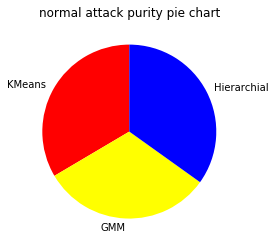

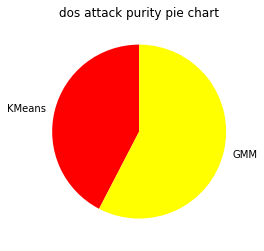

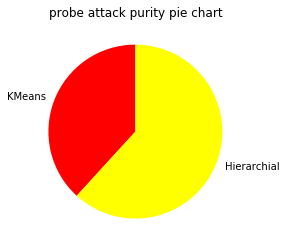

In [157]:
import matplotlib.pyplot as plt
slices_hours = [(0.7369589345172031+0.7369589345172031)/2,(0.4875647668393782+0.4727219965177017+0.8225926847474496+1)/4,(1+0.5348117793580008)/2]
activities = ['KMeans', 'GMM','Hierarchial']
colors = ['r', 'yellow','blue']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('normal attack purity pie chart')
plt.show()
plt.show()

slices_hours = [(0.48864864864864865+  0.9826061748079432)/2,1]
activities = ['KMeans', 'GMM']
colors = ['r', 'yellow']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('dos attack purity pie chart')
plt.show()
plt.show()

slices_hours = [0.9277777777777778,(1+1/2)]
activities = ['KMeans', 'Hierarchial']
colors = ['r', 'yellow']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('probe attack purity pie chart')
plt.show()
plt.show()

# multilayer autoencoder

In [35]:
import pandas as pd
import numpy as np
IntrusionData = pd.read_csv('data.csv',sep=',',index_col = False)
Xmatrix = IntrusionData.values
LabelVector = Xmatrix[:,-1]
Xmatrix = Xmatrix[:,:-1]
meanVector = np.mean(Xmatrix,axis = 0)
CenteredXmatrix = Xmatrix - meanVector
SdVector = np.std(CenteredXmatrix.astype(float),axis = 0)
CenteredXmatrix /= SdVector
Xmatrix1 = CenteredXmatrix

In [46]:
inputeLayerSize = 29
hiddenLayerSize = 10
outputLayerSize = 29
#numOfHiddenLayers = 1
#initialize weights and biases 
Weights ={}
Biases ={}
hiddenLayerSizes1 = [27,25,23,20,14,20,23,25,27]
#hiddenLayerSizes1 = [20,14,20]
#hiddenLayerSizes1 = [14]
numOfHiddenLayers = len(hiddenLayerSizes1)

#method = 'linear'
method = 'Sigmoid'
#method = 'Relu'
#method = 'tanhx'

In [53]:
for i in range(0,len(hiddenLayerSizes1)):
    if(i==0):        
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],inputeLayerSize)*np.sqrt(2/inputeLayerSize)
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/inputeLayerSize)
    else:
        Weights[i] = np.random.randn(hiddenLayerSizes1[i],hiddenLayerSizes1[i-1])*np.sqrt(2/hiddenLayerSizes1[i-1])
        Biases[i] = np.random.randn(hiddenLayerSizes1[i],1)*np.sqrt(2/hiddenLayerSizes1[i-1])

Weights[numOfHiddenLayers] = np.random.randn(outputLayerSize,hiddenLayerSizes1[numOfHiddenLayers-1])*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])
Biases[numOfHiddenLayers] = np.random.randn(outputLayerSize,1)*np.sqrt(2/hiddenLayerSizes1[numOfHiddenLayers-1])

In [7]:
for i in Weights:
    Weights[i] = 0.01*Weights[i]
    Biases[i] = 0.01*Biases[i]

In [54]:
for i in Weights:
    print(Weights[i].shape)

(27, 29)
(25, 27)
(23, 25)
(20, 23)
(14, 20)
(20, 14)
(23, 20)
(25, 23)
(27, 25)
(29, 27)


In [55]:
def getSigmoid(x,method):
    x = x.astype(float)
    if(method == 'Sigmoid'):
        x = np.clip(x,-500,500)
        return 1/(1+np.exp(-x))        
    elif(method == 'Relu'):
        #x = np.clip(x,-500,+500)
        return np.maximum(x, 0)
        #return (abs(x) + x) / 2         
    elif(method == 'tanhx'):
        return (2*(getSigmoid(2*x,'Sigmoid')))-1
    elif(method == 'linear'):
        return x
    
def getSigmoidDash(x,method):
    if(method == 'Sigmoid'):
        tempDer3 = x.copy()
        tempDer3[tempDer3.all()>-500 and tempDer3.all()<500] = 1.0
        tempDer3[tempDer3.all()>500 and tempDer3.all()<-500] = 0.0
        #tempDer1 = np.array([1.0 if (t.any()>-500 and t.any()<500) else 0.0 for t in x])
        #tempDer1 = tempDer1.reshape(x.shape[0],x.shape[1])
        tempDer2 = getSigmoid(x,method)*(1-getSigmoid(x,method))
        return tempDer2*tempDer3
        return getSigmoid(x,method)*(1-getSigmoid(x,method))
    elif(method == 'Relu'):
        x[x<=0] = 0
        x[x>0] = 1.0        
        return x
    elif(method == 'tanhx'):
        return (1 - (getSigmoid(x,'tanhx'))**2)
    elif(method == 'linear'):
        return x/x

Xmatrix.T.shape #24998

In [50]:
Xmatrix1 = Xmatrix1[0:24900,:]

In [56]:
TrainErrorInEachEpoch = []
ValErrorInEachEpoch = []
numOfIterInEachEpochs = 100
batchSize = 249
for epoch in range(0,300):
    print("Epoch is "+str(epoch))
    for j in range(0,numOfIterInEachEpochs):
        #print("Iteration is "+str(j))
        Xmatrix = Xmatrix1[0+(j*batchSize):batchSize+(j*batchSize),:]
        #Xmatrix = train.iloc[0+(j*batchSize):batchSize+(j*batchSize),1:].values    
        #Yvector = train.iloc[0+(j*batchSize):batchSize+(j*batchSize),0].values
        #print(str(0+(j*batchSize))+str(" - ")+str(batchSize+(j*batchSize)))
        #forward pass
        z = {}
        z[-1] = Xmatrix.T
        for i in range(0,numOfHiddenLayers):#np.reshape(a, (3,1))
            if(i==0):
                z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
                #print(z[i].shape)
            else:                
                z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
                #print(z[i].shape)        
        z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]
        Yhat = z[numOfHiddenLayers].astype(float)
        YvectorModified = z[-1].astype(float)
        Cost = np.linalg.norm(Yhat-YvectorModified, ord=2)
        #Cost = np.sum((np.array(Yhat-YvectorModified)**2).sum(axis=0))        
        
        #print(Cost)
        
        #backwardprop
        
        GradWeights = {}
        GradBiases = {}

        DcostDAct = {}

        DcostDAct[numOfHiddenLayers-1] = ((Weights[numOfHiddenLayers].T)@(Yhat-YvectorModified))
        
        for temp3 in range(numOfHiddenLayers-2,0,-1):
            DcostDAct[temp3] = (Weights[temp3+1].T)@(getSigmoidDash(z[temp3+1],method)*DcostDAct[temp3+1])  
        
        DcostDAct[0] = (Weights[1].T)@(1*DcostDAct[1])
        
        GradWeights[numOfHiddenLayers] = (Yhat-YvectorModified)@(z[numOfHiddenLayers-1].T)
        GradBiases[numOfHiddenLayers] = (Yhat-YvectorModified).sum(axis=1)
        
        for temp1 in range(numOfHiddenLayers-1,0,-1):
            GradWeights[temp1] = ((getSigmoidDash(z[temp1],method)*DcostDAct[temp1])@getSigmoid(z[temp1-1].T,method))
            GradBiases[temp1] = (getSigmoidDash(z[temp1],method)*DcostDAct[temp1]).sum(axis=1)
            
        GradWeights[0] = ((DcostDAct[0])@(z[-1].T.astype(float)))
        GradBiases[0] = (DcostDAct[0]).sum(axis=1) 
      
        for item in GradBiases:
            GradBiases[item] = GradBiases[item].reshape(GradBiases[item].shape[0],1)
          
        
       
        #finding gradients and updating weights and biases      
            
        for temp6 in Weights:
            Weights[temp6] =  Weights[temp6] - ((5*10**(-4))*GradWeights[temp6])
        for temp7 in Biases:
            Biases[temp7] = Biases[temp7] - ((5*10**(-4))*GradBiases[temp7]) #*(1/batchSize)           
    print(Cost)    
    #trainError = getError(train,Weights,Biases,numOfHiddenLayers,'yes')
    #valError = getError(val,Weights,Biases,numOfHiddenLayers,'no')
    #TrainErrorInEachEpoch.append(trainError)
    #ValErrorInEachEpoch.append(valError)
    #print(trainError)
    #print(valError)
    #if(epoch == 14):
    #Cost = getLoss(train,Weights,Biases,numOfHiddenLayers)
    #print(Cost)
    #ValErrorInEachEpoch.append(Cost)
     #   CostAtEndOffiftyEpochs[numOfHiddenLayers]=(getLoss(train,Weights,Biases,numOfHiddenLayers))
    #if(valError > trainError):
     #   break


Epoch is 0
40.951018753267746
Epoch is 1
40.93761015553357
Epoch is 2
40.93063188385196
Epoch is 3
40.92641378484921
Epoch is 4
40.92359973781755
Epoch is 5
40.921594943681335
Epoch is 6
40.92009869727403
Epoch is 7
40.91894250775145
Epoch is 8
40.91802442681304
Epoch is 9
40.917279014688326
Epoch is 10
40.91666226986569
Epoch is 11
40.91614348513313
Epoch is 12
40.91570057104147
Epoch is 13
40.91531723139745
Epoch is 14
40.9149811834147
Epoch is 15
40.914682995123215
Epoch is 16
40.91441530231274
Epoch is 17
40.914172266979584
Epoch is 18
40.91394919406395
Epoch is 19
40.91374225462724
Epoch is 20
40.91354828220566
Epoch is 21
40.91336462044003
Epoch is 22
40.91318900722406
Epoch is 23
40.913019485213404
Epoch is 24
40.91285433156558
Epoch is 25
40.9126920018102
Epoch is 26
40.91253108412984
Epoch is 27
40.91237026128527
Epoch is 28
40.912208278077195
Epoch is 29
40.91204391269648
Epoch is 30
40.911875950626936
Epoch is 31
40.91170315997265
Epoch is 32
40.91152426720558
Epoch is 33
40

19.00542453977489
Epoch is 265
18.94403315006667
Epoch is 266
18.93188090881657
Epoch is 267
18.91475996047122
Epoch is 268
19.105061690148396
Epoch is 269
18.936698469725876
Epoch is 270
19.020648960455425
Epoch is 271
18.902605469165493
Epoch is 272
18.99695044968329
Epoch is 273
18.891169029392994
Epoch is 274
18.88695386649597
Epoch is 275
18.769857035131757
Epoch is 276
18.877148611476947
Epoch is 277
18.47494192743849
Epoch is 278
18.212183865819043
Epoch is 279
18.18274262955135
Epoch is 280
17.96834171500538
Epoch is 281
17.799544428640438
Epoch is 282
17.131166841736352
Epoch is 283
17.300426123037717
Epoch is 284
17.612567487397126
Epoch is 285
17.052312449617535
Epoch is 286
17.23838380725304
Epoch is 287
17.096767945383203
Epoch is 288
17.106675629378042
Epoch is 289
17.084332954191904
Epoch is 290
17.106767619246646
Epoch is 291
17.104965544300214
Epoch is 292
17.33191389184211
Epoch is 293
17.16537947384662
Epoch is 294
17.123796008730636
Epoch is 295
17.04828697640674
Ep

In [ ]:
z = {}
z[-1] = Xmatrix1.T
for i in range(0,5):#np.reshape(a, (3,1))
    if(i==0):
        z[i] = (Weights[i]@z[-1].astype(float))+Biases[i]  
        #print(z[i].shape)
    else:                
        z[i]= (Weights[i]@getSigmoid(z[i-1],method))+Biases[i]
        #print(z[i].shape)        
#z[numOfHiddenLayers] = (Weights[numOfHiddenLayers]@z[numOfHiddenLayers-1])+Biases[numOfHiddenLayers]

In [30]:
reconstructedXmatrix = z[4].T

In [32]:
reconstructedXmatrix.shape

(24998, 14)

In [33]:
len(reconstructedXmatrix)

24998

PART2

In [163]:
k = 5
meanVector = {}
import random
RandomIndices = random.sample(range(0,len(reconstructedXmatrix)), 5)
#RandomIndices = [15126, 24342, 8449, 19992, 6418]
print(RandomIndices)
for i in range(0,k):
    #meanVector[i] = 
    meanVector[i] = reconstructedXmatrix[RandomIndices[i],:]

[4676, 8660, 14524, 20961, 2125]


In [124]:
def getDistance(row1,row2):
    row1 = np.array(row1)
    row2 = np.array(row2)
    return (np.sum((np.abs(row1-row2))**2))**(1/2)
def getNearestClusterDistance(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    #nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanDistance
def getNearestCluster(givenSample,meanVector1):
    distancesFromAllMeans = {}
    for i in meanVector1:
        distancesFromAllMeans[i] = getDistance(givenSample,meanVector1[i])
    nearestMeanLabel = min(distancesFromAllMeans.items(), key=operator.itemgetter(1))[0]
    #nearestMeanDistance = min(distancesFromAllMeans.values()); 
    return nearestMeanLabel

In [164]:
iterationNumber = 0
#while (iterationNumber<30):
AssociatedClusterForEachPoint1 = []
import operator
while(True):
#for i in range(0,10)
    iterationNumber += 1
    print("iteration number "+str(iterationNumber))
    beforeAssociatedClusterForEachPoint1 = AssociatedClusterForEachPoint1.copy()
    AssociatedClusterForEachPoint1 = []
    for i in range(0,len(reconstructedXmatrix)):
        AssociatedClusterForEachPoint1.append(getNearestCluster(reconstructedXmatrix[i,:],meanVector))
    if(beforeAssociatedClusterForEachPoint1 == AssociatedClusterForEachPoint1):
        break
    distanceOfallPointsToTheirNearestMeans = 0
    for i in range(0,len(reconstructedXmatrix)):
        distanceOfallPointsToTheirNearestMeans += (getNearestClusterDistance(reconstructedXmatrix[i,:],meanVector))
    print('distanceOfallPointsToTheirNearestMeans is '+str(distanceOfallPointsToTheirNearestMeans))
    #distanceOfallPointsToTheirNearestMeans = 0
    for i in meanVector:
        numerVector = np.array([0.0]*len(meanVector[0]))
        count = 0
        for j,value in enumerate(AssociatedClusterForEachPoint1):
            if value == i:
                numerVector += reconstructedXmatrix[j,:]
                #print(reconstructedXmatrix[j,:])
                count += 1
        if count!= 0:
            print("centriod number - "+str(i)+" have points "+str(count))            
            meanVector[i] = (numerVector/count)
        else:
            print('no points associated to mean number')
            print(i)    

iteration number 1
distanceOfallPointsToTheirNearestMeans is 95970.44511454033
centriod number - 0 have points 1977
centriod number - 1 have points 10914
centriod number - 2 have points 3642
centriod number - 3 have points 5742
centriod number - 4 have points 2723
iteration number 2
distanceOfallPointsToTheirNearestMeans is 48784.11131782043
centriod number - 0 have points 2410
centriod number - 1 have points 10272
centriod number - 2 have points 4367
centriod number - 3 have points 5670
centriod number - 4 have points 2279
iteration number 3
distanceOfallPointsToTheirNearestMeans is 49194.46158290226
centriod number - 0 have points 2460
centriod number - 1 have points 10270
centriod number - 2 have points 4369
centriod number - 3 have points 5670
centriod number - 4 have points 2229
iteration number 4
distanceOfallPointsToTheirNearestMeans is 49217.02356325282
centriod number - 0 have points 2506
centriod number - 1 have points 10270
centriod number - 2 have points 4369
centriod numbe

In [165]:
conMatrix = pd.crosstab(np.array(AssociatedClusterForEachPoint1),LabelVector)

In [166]:
tempo = pd.DataFrame(conMatrix)
tempo

col_0,dos,normal,probe,r2l,u2r
row_0,,,,,
0,2400,91,13,3,0
1,296,9329,595,43,7
2,623,3021,674,51,0
3,3614,922,1031,100,3
4,2181,1,0,0,0


In [167]:
tempo['label']=tempo.idxmax(axis=1)

In [168]:
for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))

purity of cluster 0 is 0.9573195053849222 and its label is dos
purity of cluster 1 is 0.9083739045764362 and its label is normal
purity of cluster 2 is 0.6914625772487983 and its label is normal
purity of cluster 3 is 0.6373897707231041 and its label is dos
purity of cluster 4 is 0.9995417048579285 and its label is dos


GMM

In [169]:
from sklearn import mixture
#clusterer = GaussianMixture(5, 'diag')
#clusterer.fit(reconstructedXmatrix)
#cluster_labels = clusterer.predict(reconstructedXmatrix)
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full',
                              max_iter=400,random_state= 0,n_init=20, init_params='kmeans').fit(reconstructedXmatrix)
labels = gmm.predict(reconstructedXmatrix)
zippedLabel = zip(labels,LabelVector)
conMatrix = pd.crosstab(labels,LabelVector)
#print(conMatrix)
tempo1 = pd.DataFrame(conMatrix)
tempo1

col_0,dos,normal,probe,r2l,u2r
row_0,,,,,
0,148,6258,42,0,0
1,4578,82,13,3,0
2,3614,922,1031,100,3
3,148,3076,554,43,7
4,626,3026,673,51,0


In [170]:
tempo1['label']=tempo1.idxmax(axis=1)

In [171]:
for i in tempo1.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo1.iloc[[i],:-1].values))/np.sum(np.array(tempo1.iloc[[i],:-1].values)))+" and its label is "+str(tempo1.at[i,'label']))

purity of cluster 0 is 0.9705334987593052 and its label is normal
purity of cluster 1 is 0.9790419161676647 and its label is dos
purity of cluster 2 is 0.6373897707231041 and its label is dos
purity of cluster 3 is 0.8035527690700105 and its label is normal
purity of cluster 4 is 0.6914990859232175 and its label is normal


HAC

In [173]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5,affinity='euclidean', linkage='single',compute_full_tree = 'auto') .fit(reconstructedXmatrix)
clustering 
#[0:30000,:]compute_full_tree : false
#AgglomerativeClustering(n_clusters=10,   
# affinity=‘cosine’, linkage=‘complete’)
#AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
 #           connectivity=None, linkage='ward', memory=None, n_clusters=2,
  #          pooling_func='deprecated')
#clustering.labels_
#array([1, 1, 1, 0, 0, 0])
#memory=None,

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='single', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [174]:
labelsForAgClus = clustering.labels_

In [175]:
conMatrix = pd.crosstab(labelsForAgClus,LabelVector)

In [176]:
print(conMatrix)

col_0   dos  normal  probe  r2l  u2r
row_0                               
0      9110   13363   2310  196   10
1         4       0      2    0    0
2         0       0      0    1    0
3         0       0      1    0    0
4         0       1      0    0    0


In [177]:
tempo = pd.DataFrame(conMatrix)
#tempo1
tempo['label']=tempo.idxmax(axis=1)

for i in tempo.index:
    print('purity of cluster '+str(i)+" is "+str(np.max(np.array(tempo.iloc[[i],:-1].values))/np.sum(np.array(tempo.iloc[[i],:-1].values)))+" and its label is "+str(tempo.at[i,'label']))

purity of cluster 0 is 0.5347552923286246 and its label is normal
purity of cluster 1 is 0.6666666666666666 and its label is dos
purity of cluster 2 is 1.0 and its label is r2l
purity of cluster 3 is 1.0 and its label is probe
purity of cluster 4 is 1.0 and its label is normal


purity of cluster 0 is 0.9573195053849222 and its label is dos
purity of cluster 1 is 0.9083739045764362 and its label is normal
purity of cluster 2 is 0.6914625772487983 and its label is normal
purity of cluster 3 is 0.6373897707231041 and its label is dos
purity of cluster 4 is 0.9995417048579285 and its label is dos

purity of cluster 0 is 0.9705334987593052 and its label is normal
purity of cluster 1 is 0.9790419161676647 and its label is dos
purity of cluster 2 is 0.6373897707231041 and its label is dos
purity of cluster 3 is 0.8035527690700105 and its label is normal
purity of cluster 4 is 0.6914990859232175 and its label is normal

purity of cluster 0 is 0.5347552923286246 and its label is normal
purity of cluster 1 is 0.6666666666666666 and its label is dos
purity of cluster 2 is 1.0 and its label is r2l
purity of cluster 3 is 1.0 and its label is probe
purity of cluster 4 is 1.0 and its label is normal

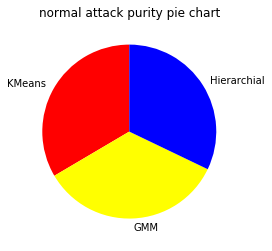

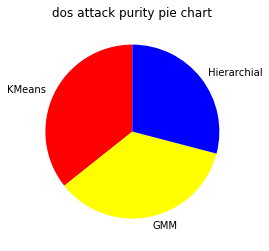

In [161]:
import matplotlib.pyplot as plt
slices_hours = [(0.9083739045764362+0.6914625772487983)/2,( 0.9705334987593052+0.8035527690700105+  0.6914990859232175)/3,( 0.5347552923286246+1.0)/2]
activities = ['KMeans', 'GMM','Hierarchial']
colors = ['r', 'yellow','blue']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('normal attack purity pie chart')
plt.show()
plt.show()

slices_hours = [(0.6373897707231041+0.9995417048579285)/2,( 0.9790419161676647+0.6373897707231041)/2, 0.6666666666666666]
activities = ['KMeans', 'GMM','Hierarchial']
colors = ['r', 'yellow','blue']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
plt.title('dos attack purity pie chart')
plt.show()
plt.show()

slices_hours = [0.8070866141732284,1]
activities = ['KMeans', 'Hierarchial']
colors = ['r', 'yellow']
#plt.pie(slices_hours, labels=activities, colors=colors, startangle=90)#, autopct='%.1f%%')
#plt.title('probe attack purity pie chart')
#plt.show()
#plt.show()